# Artificial Neural Network Analysis On Shopping Behaviors

### The Problem 
A company with both a brick-and-mortar store and an online store wants to improve customer retention rates and incentivise current customers to make future purchases from their physical location. They plan to achieve this by offering customers who are currently checking out on their website a "*40% Off Your Next Purchase*" coupon only redeemable for in-store purchases.

Given a dataset with information on customers who have previously made a purchase from the store, determine if a customer who is currently checking out on the company's website is likely to make a future purchase in store. If they are more likely to make a future purchase in store, the company will email them the coupon to incentivise them to come into the store next time instead.


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Data Preprocessing

First, note that the categorical variable "region" has already been preprocessed by the owner of the dataset. The author has not defined what actual geographic location corresponds to which region code, so in the “Initial Observations” section of the tutorial, I will be making generalizations about these regions.


Secondly, the independent variable "in.store" takes two values: 0 and 1. Let us denote 0 for a purchase made online and 1 for a purchase made in store.


Lastly, please note that I have omitted the columns "ip.address" and "full.name" from the implementation of the model. While it is entirely possible to categorize data entries by geographic location using the provided IP address, when considering the number of entries in the dataset (80,000) and the number of possible IP address regions (in the thousands, if not tens of thousands) it was simply too tedious to sort through all the IP addresses and categorize them for the purpose of this tutorial. Similarly, it is possible to categorize customers into gendered groups, but with such diversity of names, it was not practical to categorize the customers within a reasonable timeframe. Part of this decision was also rooted in caution because I did not want to accidentally misgender a customer. A solution to these issues is provided in the analysis section.


In [ ]:
dataset = pd.read_csv('Demographic_Data.csv');
dataset[dataset.isna().any(axis=1)].fillna(np.nan);

X = dataset.iloc[:, [3,5,6,7]];
y = dataset.iloc[:, 4];

In [ ]:
print(X.iloc[:10, :]);

   region  age  items     amount
0       2   37      4   281.0300
1       2   35      2   219.5100
2       4   45      3  1525.7000
3       3   46      3   715.2500
4       1   33      4  1937.5000
5       4   24      3  1314.2000
6       2   43      6     8.5472
7       3   66      5   819.9800
8       1   51      5   908.3100
9       1   47      3   767.5400


In [ ]:
print(y.iloc[:10]);

0    0
1    0
2    1
3    1
4    1
5    0
6    0
7    1
8    1
9    1
Name: in.store, dtype: int64


### Splitting The Data Into Train and Test Sets 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2);

### Feature Scaling 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler();
X_train = scaler.fit_transform(X_train);
X_test = scaler.fit_transform(X_test);

# Initial Observations 

Before training the neural network, I will use the given data to make initial predictions about the relationship between the features and whether or not a customer will purchase in store or online. 

In [ ]:
# Calculating the total number of customers from each region who made a purchase in store
region_count = np.zeros(4);

for i in range(len(y)):
  if y[i] == 1:
    if X.iloc[i, 0] == 1:
      region_count[0] = region_count[0] + 1;
    elif X.iloc[i, 0] == 2:
      region_count[1] = region_count[1] + 1;
    elif X.iloc[i, 0] == 3:
      region_count[2] = region_count[2] + 1;
    elif X.iloc[i, 0] == 4:
      region_count[3] = region_count[3] + 1;

In [ ]:
# Calculating the average age of customers in each region 
total_age = np.zeros(4)
count = np.zeros(4)

for i in range(len(y)):
    if X.iloc[i, 0] == 1:
      total_age[0] = total_age[0] + X.iloc[i,1];
      count[0] = count[0] + 1;
    elif X.iloc[i, 0] == 2:
      total_age[1] = total_age[1] + X.iloc[i,1];
      count[1] = count[1] + 1;
    elif X.iloc[i, 0] == 3:
      total_age[2] = total_age[2] + X.iloc[i,1];
      count[2] = count[2] + 1;
    elif X.iloc[i, 0] == 4:
      total_age[3] = total_age[3] + X.iloc[i,1];
      count[3] = count[3] + 1;

average_age = np.zeros(4)
for i in range(4):
  average_age[i] = total_age[i] / count[i]

print(average_age)

[43.7039375  56.61035    45.64694444 38.75073077]


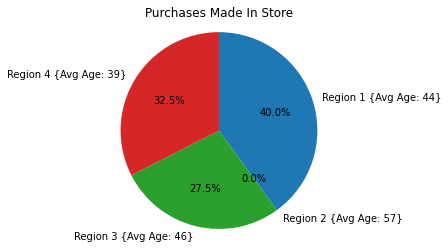

In [ ]:
# Graphing the number of purchases made in store by region 
labels = 'Region 1 {Avg Age: 44}', 'Region 2 {Avg Age: 57}', 'Region 3 {Avg Age: 46}', 'Region 4 {Avg Age: 39}'
sizes = [region_count[0], region_count[1], region_count[2], region_count[3]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, counterclock=False, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Purchases Made In Store")
plt.show()

After this initial analysis, we notice the people living in regions 1, 3 and 4 make up the entirety of purchases made in store, and no members of region 2 made purchases in store. It is possible that region 2 is located geographically distant from the physical store, disincentivizing people of region 2 from making purchases in store. We may also notice that people living in region 2 are also the oldest on average. This could be indicative of preference in shopping habits based on age.

# Building The Artificial Network 

In this section I will create the Artificial Neural Network. The input layer and any proceeding layers (excluding the output layer) will have an activation function of the Rectifier type. The output layer will have an activation function of the Sigmoid type.


The first iteration of the for loop adds the input layer and first hidden layer. Any additional iterations of the loop will add additional hidden layers. A final output layer will be created outside the for loop because this layer has a different activation function type. The number of hidden layers as well as the dimension of the output will be experimented with and the results will be summarized in the "Summary of Test Results" section at the end of the “Training The Artificial Network” section. The dimension of the output layer is set to 1 because the desired output of the model (whether a person will purchase online or in store) is represented in binary form. 

In [ ]:
ANN = tf.keras.models.Sequential(); 
Layers = tf.keras.layers;

In [ ]:
layer_count = 2; # controls number of layers in the neural network
dimension = 6; # controls dimension of the output space of the hidden layers

for i in range(layer_count):
  ANN.add(Layers.Dense(units=dimension, activation='relu'));

ANN.add(Layers.Dense(units=1, activation='sigmoid'));

# Training The Artificial Network

In this section, I will train the artificial neural network. Here, I have chosen the Adam optimization method because of its effective use of the stochastic gradient descent method on less complex sets of data. Because the desired output of the network is in binary, I have chosen the loss function to be binary cross entropy. Finally, I have chosen the ‘accuracy’ metric because the accuracy metric calculates the frequency in which y_pred matches y_true and this frequency is returned as binary accuracy.

In [ ]:
ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']);

In [ ]:
ANN.fit(X_train, y_train, batch_size=500, epochs=1000);

### Summary of Test Results

- Layer Count: 3,
Dimension: 6,
Batch size: 500,
Epochs: 1000,
Training Time: 6 mins,
Final Loss: 22.6%
Final accuracy: 88.62%

- Layer Count: 3,
Dimension: 7,
Batch size: 500,
Epochs: 1000,
Training Time: 4 mins,
Final Loss: 22.67%
Final accuracy: 88.63%

- Layer Count: 3,
Dimension: 8,
Batch size: 500,
Epochs: 1000,
Training Time: 8 mins,
Final Loss: 22.74%
Final accuracy: 88.62%

- Layer Count: 4,
Dimension: 7,
Batch size: 500,
Epochs: 1000,
Training Time: 9 mins,
Final Loss: 22.66%
Final accuracy: 88.54%

- Layer Count: 4,
Dimension: 7,
Batch size: 250,
Epochs: 500,
Training Time: 8 mins,
Final Loss: 69.32%
Final accuracy: 49.76%. 
(Not sure what happened here, I possibly had some internet connectivity issues.) 

- Layer Count: 3,
Dimension: 6,
Batch size: 500,
Epochs: 1000,
Training Time: 7 mins,
Final Loss: 22.54%%
Final accuracy: 88.70%

- Layer Count: 2,
Dimension: 6,
Batch size: 500,
Epochs: 1000,
Training Time: 7 mins,
Final Loss: 22.94%%
Final accuracy: 88.49%

Through all the trials, the results hardly differed with changing inputs. I will be staying with settings of the last trial because it has similar results to the other trials, the model trains fairly quickly, and the settings resulted in the highest accuracy rate. 

# Predicting The Test Set Results 

In [ ]:
y_pred = ANN.predict(X_test);
y_pred = (y_pred > 0.5); # converts probabilities into boolean binary outcome 
y_test = (y_test > 0.5);

500/500 [==============================] - 1s 1ms/step


## Confusion Matrix and Accuracy of the Network Model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred);
print(cm);

[[6173 1798]
 [  18 8011]]


In [ ]:
print(accuracy_score(y_test, y_pred));

0.8865


The accuracy of this model ranges from 80% - 90%.

# Making Future Predictions 

The company has gathered information on customers who are currently checking out on their website and wants to determine which customers to email the coupon:

In [ ]:
customers = pd.read_csv('Future_Customers.csv');
x = customers.iloc[:, 2:];
x = scaler.fit_transform(x);

In [ ]:
print(customers.iloc[:, 1]);

0      Kaitlin Terry
1      Wilson Crooks
2      Nell Parisian
3         Portia Von
4       Kareen Wyman
5    Daniel Saunders
6        Nate Kappus
7        Summer Howe
8         Jill King 
9       Patrick Kihn
Name: full.name, dtype: object


In [ ]:
print(ANN.predict(x) > 0.5);

1/1 [==============================] - 0s 122ms/step
[[False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]]


According to our model's predictions, we should email Nell Parisian, Portia Von, Kareen Wyman, Jill King, and Patrick Kihn the coupon. 

# Analysis and Summary 

## Summary 
For a first implementation, this model performed at a higher level than expected.


In the "Initial Observations" section of the tutorial, I explored any pre-existing biases in the data and drew conclusions.


After building the model, I performed several experiments to determine the highest performing parameters in which to train the model. Through experimentation, I determined that the number of hidden layers and the dimension of the output space had little effect on the final results. If I were to increase the number of epochs, I believe that the accuracy of the model could improve. However, considering the model already performs with an excellent accuracy rate and trains in less than 10 minutes, I will leave the model as is.


After training the model, I used data that I had set aside for testing to build a confusion matrix and test the accuracy of the model. I then used new data to make predictions on whether or not the company should email a customer a coupon.


### Biases
The objective goal of this tutorial contains a hidden bias that was not addressed: if a customer is already checking out on the company’s website, it is likely they have the preference to shop online in the future. In a future implementation of this model, this bias could be addressed by adding a new feature to the dataset: a feature that counts the number of online purchases a customer has made in the past, if any. 


It is possible that gender has an influence on whether or not a customer is likely to purchase in store or online. In a future implementation, this idea could be explored by collecting more data on the customers and asking them to provide their pronouns to allow for proper gender categorization.


The IP address of a customer contains valuable information that was not included in the implementation of the model; it contains information on a customer’s geographic location. In a future implementation, it would be worth taking the time to sort and categorize customers based on their IP address and retrain the model with this information.


As was explored in the "Initial Observations" section, region likely has an impact on a customers decision to shop in store. Considering the fact that zero customers from region 2 made a purchase in store, we can make an educated guess that the physical location of the store is not geographically close to region 2.


## Conclusion
Although the model performed with excellent accuracy, there is always room for improvement. After working with the data, I would suggest that the company collect more data on their customers preferred gender, and track the number of purchases a customer has made with the company in the past and whether those purchases were made in store or online.


If the company is interested in increasing the number of in-store sales, they might consider opening another location in or near region 2 to incentivise customers of that region to make future purchases in store rather than online.

### Credits 
Nowicki, Joseph, January 2023, "Sales data based on demographics", https://www.kaggle.com/datasets/thedevastator/demographical-shopping-purchases-data